## Прогнозная модель для датасета Drug consumption Data

###### Импорт необходимых библиотек 

In [280]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt

###### Загрузка датасета 

In [24]:
data = pd.read_csv('drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Датасет состоит из 12 категориальных признаков, каждый из которых представляет собой в виде обозначения вещественное число. Остальные столбцы (19 столбцов) являются целевыми переменными, то есть на основе 12 признаков итоговая модель или модели должны предсказать 19 различных классов, каждый из которых дополнительно делится на данные метки: CL0 - Never Used, CL1 - Used over a Decade Ago, CL2 - Used in Last Decade, CL3 - Used in Last Year, CL4 - Used in Last Month, CL5 - Used in Last Week, CL6 - Used in Last Day.

Подробнее о признаках и целевых переменных можно узнать на странице датасета: [ссылка](https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29).

Таким образом, стоит задача мультиклассовой классификации, причем у каждого класса имеется больше 2ух меток (multilabel multiclass classification).

Задача будет решена в два способа: 
- в первом случае метки классов будут упразднены до двух меток, как предлагается на странице датасета, то есть задача перейдет к мультиклассовой классификации с двумя метками (multilabel classification), что будет гораздо проще; 
- во втором случае для каждого из классов будет создана своя модель, то есть задача сведется к простой мультиклассовой классификации (multiclass classification).

###### Анализ данных 

### Способ №1 (переход к multilabel classification)

###### Преобразование датасета

Для начала, следует преобразовать категориальные признаки в датасете, чтобы они правильно читались моделью. Также нужно немного видоизменить сами целевые метки: сократить их до двух и перевести в формат 0 или 1.

In [71]:
# Деление на признаки и целевые переменные
X = data.drop(data.columns[np.arange(12, 31, 1)], axis=1)
y = data.iloc[:, 12:31]

In [75]:
# форматирование вещественных чисел в признаках в string
# для более адекватного последующего преобразования категориальных признаков
X = X.astype(str)
X.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.126,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.6209,-1.0145,-1.37983,0.40148
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.6334,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


Не смотря на то, что признаков достаточно много, как и уникальных значений у каждого признака, в данной работе будут использоваться все признаки для обучения. Перейдем к кодированию категориальных признаков.

In [82]:
enc = OneHotEncoder()
X_categorized = enc.fit_transform(X).toarray()
X = pd.DataFrame(X_categorized)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Признаки были надлежащим образом закодированы, далее перейдем к изменению целевых меток.

Как было предложено в описании датасета, изменение целевых меток будет произведено следующим образом:
- Метки "CL0 - Never Used" и "CL1 - Used over a Decade Ago" можно обозначить как "Non-user" или 0
- Остальные метки можно обозначить как "User" или 1

In [99]:
y = pd.DataFrame(np.where(np.logical_or(y == 'CL0', y == 'CL1'), 0, 1))
y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0
2,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0


###### Обучение и валидация модели

Теперь, когда датасет готов для передачи на обучение и тест модели, можно перейти к обозначению тестируемых моделей и к стратегии кросс-валидации.

В рамках данной работы будет использоваться библиотека sklearn, в которой для решения задач multilabel (multioutput) классификаций имеются свои собственные функции. Это _MultiOutputClassifier_ и _ClassifierChain_. Первая строит классификатор для каждой целевой метки независимо, вторая же учитывает предсказания каждого предыдущего классификатора. 

Вышеназванные функции требуют на вход классификатор, который и будет выполнять основную работу. Для начала взят случайный лес для отбора оптимальной функции, далее же будет происходить отбор различных базовых классификаторов для последующего подбора оптимальных параметров.

Так как для данного вида задач стандартная метрика не подходит, будет создана своя собственная. Это взвешенная F-мера, то есть учитывающая соотношение классов внутри каждой метки $y$. Помимо этого, использован дополнительный параметр _zero_division_, который будет возвращать 0 или 1 в случае, если при подсчете F-меры возникает деление на 0 (при классификации модель видела только один класс, что возможно).

In [176]:
scorer = make_scorer(f1_score, average='weighted', zero_division=1)

Для поиска оптимальной для задачи функции multilabel классификации сравним их результат на кросс-валидации на 5 фолдов. 

In [191]:
random_forest = RandomForestClassifier()
score_moc = cross_val_score(MultiOutputClassifier(random_forest), X, y, scoring=scorer, cv=5)
score_cc = cross_val_score(ClassifierChain(random_forest), X, y, scoring=scorer, cv=5)

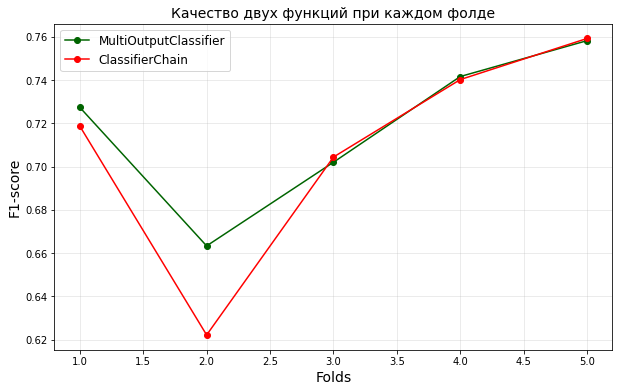

In [207]:
x = range(1, 6)
plt.figure(figsize=(10,6))
plt.plot(x, score_moc, marker='o', color='darkgreen')
plt.plot(x, score_cc, marker='o', color='red')
plt.grid(alpha=0.3)
plt.xlabel('Folds', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.title('Качество двух функций при каждом фолде', fontsize=14)
plt.legend(['MultiOutputClassifier', 'ClassifierChain'], fontsize=12)
plt.show()

In [209]:
print(f'Среднее значение качества у MultiOutputClassifier: {round(score_moc.mean(), 4)}')
print(f'Среднее значение качества у ClassifierChain: {round(score_cc.mean(), 4)}')

Среднее значение качества у MultiOutputClassifier: 0.7185
Среднее значение качества у ClassifierChain: 0.709


Таким образом, не смотря на то, что на некоторых фолдах две функции получили практически идентичные метрики качества, _ClassifierChain_ показал несколько более низкие результаты, поэтому в последующем будет использоваться _MultiOutputClassifier_.

Теперь перейдем к выбору наилучшего классификатора.

Выбор будет происходить между распространенными классификаторами (с параметрами по умолчанию), которые зарекомендовали себя положительно: случайный лес, метод опорных векторов, классификация при помощи стохастического градиентного спуска, и K-соседей.

In [230]:
classifiers = [SGDClassifier(), KNeighborsClassifier(), SVC(), RandomForestClassifier()]
scores = []
for clf in classifiers:
    score = cross_val_score(MultiOutputClassifier(clf), X, y, scoring=scorer, cv=5)
    scores.append((clf, score))

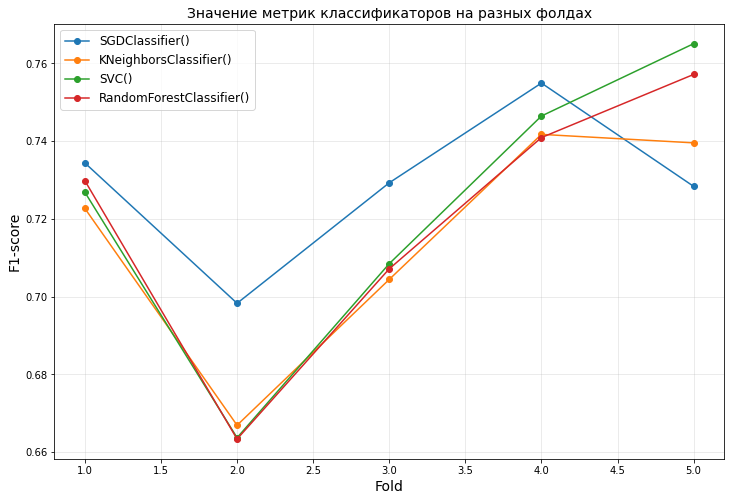

In [231]:
plt.figure(figsize=(12,8))
for score in scores:
    plt.plot(x, score[1], marker='o')
plt.xlabel('Fold', fontsize=14)
plt.ylabel('F1-score', fontsize=14)
plt.legend([str(score[0]) for score in scores], fontsize=12)
plt.title('Значение метрик классификаторов на разных фолдах', fontsize=14)
plt.grid(alpha=0.3)
plt.show()

In [232]:
for score in scores:
    print(f'Среднее значение {score[0]}: {round(score[1].mean(), 4)}')

Среднее значение SGDClassifier(): 0.729
Среднее значение KNeighborsClassifier(): 0.715
Среднее значение SVC(): 0.7221
Среднее значение RandomForestClassifier(): 0.7197


Не смотря на то, что на последних фолдах лучшие значения показывают Случайный лес и метод опорных векторов, в общем более хорошее среднее значение принимает классификатор стохастического градиентного спуска. Далее можно подробнее подобрать параметры к SGD, а также посмотреть на подбор параметров у метода опорных векторов (возможно, что классификатор покажет результат получше).

In [256]:
parameters = {
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__alpha': [val for val in np.arange(0.0001, 0.0012, 0.0005)],
    'estimator__class_weight': [None, 'balanced']
}
clf_sgd = RandomizedSearchCV(estimator=MultiOutputClassifier(SGDClassifier()), 
                             param_distributions=parameters, scoring=scorer, cv=5)
clf_sgd.fit(X, y)

c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider i

RandomizedSearchCV(cv=5,
                   estimator=MultiOutputClassifier(estimator=SGDClassifier()),
                   param_distributions={'estimator__alpha': [0.0001,
                                                             0.0006000000000000001,
                                                             0.0011],
                                        'estimator__class_weight': [None,
                                                                    'balanced'],
                                        'estimator__loss': ['hinge',
                                                            'squared_hinge'],
                                        'estimator__penalty': ['l2', 'l1']},
                   scoring=make_scorer(f1_score, average=weighted, zero_division=1))

Итоговые параметры после рандомизированного поиска по сетке:

In [261]:
clf_sgd.best_params_

{'estimator__penalty': 'l1',
 'estimator__loss': 'hinge',
 'estimator__class_weight': 'balanced',
 'estimator__alpha': 0.0006000000000000001}

In [262]:
MultiOutputClassifier(estimator=SGDClassifier(penalty='l1', class_weight='balanced', alpha=0.0006))
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_sgd.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7472


Таким образом, удалось немного, но увеличить качество модели на валидации.

In [275]:
parameters = {
    'estimator__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}
clf_svc = GridSearchCV(estimator=MultiOutputClassifier(SVC(class_weight='balanced')), 
                             param_grid=parameters, scoring=scorer, cv=5)
clf_svc.fit(X, y)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=SVC(class_weight='balanced')),
             param_grid={'estimator__C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring=make_scorer(f1_score, average=weighted, zero_division=1))

Итоговые параметры метода опорных векторов после поиска по сетке:

In [276]:
clf_svc.best_params_

{'estimator__C': 1.0}

In [279]:
print(f'Итоговое качество после нахождения наилучших параметров: {round(clf_svc.best_score_, 4)}')

Итоговое качество после нахождения наилучших параметров: 0.7646


Видно, что, по сути, качество намного увеличилось за счет указания сбалансированного веса классов в параметрах SVC, параметр регуляризации C можно было использовать стандартный.

Более того, качество SVC оказалось даже лучше, чем показатель у SGD.

Можно еще раз рассмотреть два данных классификатора и то, каким образом они обучаются.

In [286]:
train_sizes, train_scores, test_scores = learning_curve(
    MultiOutputClassifier(estimator=SGDClassifier(
        penalty='l1', class_weight='balanced', alpha=0.0006, max_iter=5000)),
    X, y, cv=5, scoring=scorer)

c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\sasha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:703: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


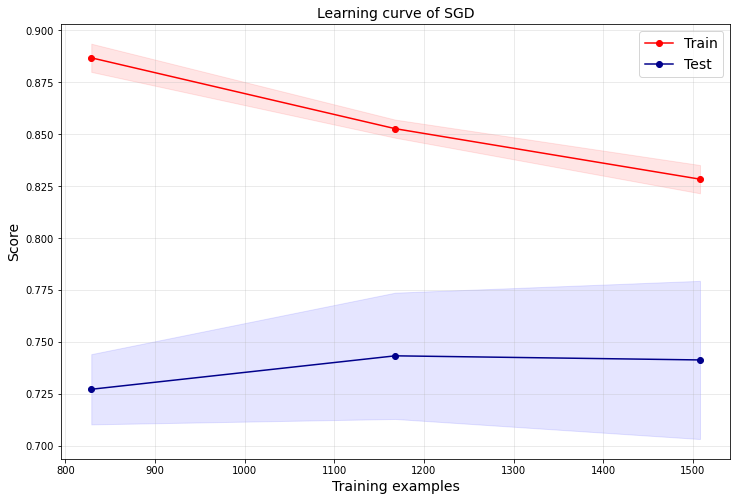

In [305]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of SGD', fontsize=14)
plt.show()

In [306]:
train_sizes, train_scores, test_scores = learning_curve(MultiOutputClassifier(SVC(
    C=1.0, class_weight='balanced')), X, y, cv=5, scoring=scorer)

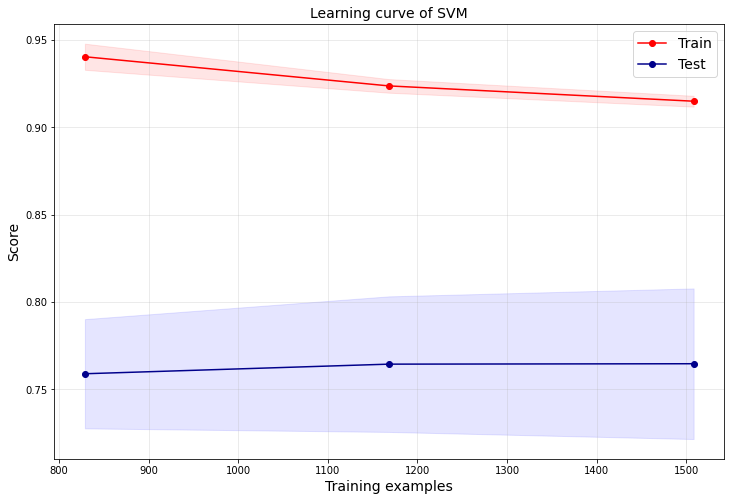

In [307]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, marker='o', color='r')
plt.grid(alpha=0.3)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.1, color="b")
plt.plot(train_sizes, test_scores_mean, marker='o', color='darkblue')
plt.xlabel('Training examples', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Learning curve of SVM', fontsize=14)
plt.show()

В итоге, удалось реализовать задачу multiclass multilabel классификации при помощи ее сведения к multilabel binary классификации. Наилучшие результаты метрики качества, подогнанной под задачу, показали метод опорных векторов и стохастический градиент.

### Способ №2 (переход к множеству multiclass classification моделей)